In [109]:
import pickle

import sympy as sp
from sympy import cos, sin
from IPython.display import display, Math
sp.init_printing()


Create figure of system

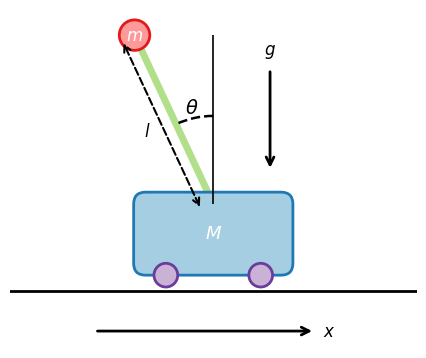

In [115]:
# Create figure of cart-pole
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Arc, Circle, FancyArrowPatch, FancyBboxPatch

colors = mpl.cm.Paired.colors
cart_fill, cart_edge = colors[0], colors[1]
pole_color = colors[2]
mass_fill, mass_edge = colors[4], colors[5]
wheel_fill, wheel_edge = colors[8], colors[9]

fig, ax = plt.subplots(figsize=(7.2, 4.4))

w = 0.8 # cart width
h = 0.35 # cart height
r = 0.07 # wheel radius
l = 1.1 # pole length
pivot = np.array([0.0, h])
pole_angle = np.deg2rad(25)

# pole
pole_end = pivot + l * np.array([-np.sin(pole_angle), np.cos(pole_angle)])
ax.plot(*zip(pivot, pole_end), color=pole_color, lw=5, zorder=-1)

# cart
cart = FancyBboxPatch((pivot[0] - w / 2, 0), w, h, boxstyle='round, pad=0.07',
facecolor=cart_fill, edgecolor=cart_edge, lw=2)
ax.add_patch(cart)

# wheels
for offset in (-0.28, 0.28):
    wheel = Circle((pivot[0] + offset, - r), r, facecolor=wheel_fill, edgecolor=wheel_edge, lw=2)
    ax.add_patch(wheel)

# ground
ax.axhline(-r*2.3, xmin=0, xmax=1, color='black', lw=2)

# tip mass
tip_mass = Circle(pole_end, 0.09, facecolor=mass_fill, edgecolor=mass_edge, lw=2)
ax.add_patch(tip_mass)

# Mass labels
ax.text(pivot[0], h / 2, r'$M$', fontsize=13, color='white', ha='center', va='center')
ax.text(pole_end[0], pole_end[1], r'$m$', fontsize=12, color='white', ha='center', va='center')

# Reference line for theta
ax.vlines(pivot[0], pivot[1], pole_end[1], color='black', linewidth=1.2)

theta_radius = 0.52; theta_deg = np.degrees(pole_angle)
ax.add_patch(Arc(tuple(pivot), width=theta_radius * 2, height=theta_radius * 2, theta1=90,
theta2=90 + theta_deg, color='black', lw=1.8, ls='dashed'))
mid_angle = np.deg2rad(90 + theta_deg / 2)
ax.text(pivot[0] + (theta_radius + 0.06) * np.cos(mid_angle),
        pivot[1] + (theta_radius + 0.06) * np.sin(mid_angle),
        r'$\theta$', fontsize=14, ha='center', va='center')

# pole length
direction_unit = pole_end - pivot / np.linalg.norm(pole_end - pivot)
normal = np.array([-direction_unit[1], direction_unit[0]])
start_l = pivot + normal * 0.07; end_l = pole_end + normal * 0.07
ax.add_patch(FancyArrowPatch(start_l, end_l, arrowstyle='<->', mutation_scale=12,
                             lw=1.5, color='black', ls='--'))
mid_l = (start_l + end_l) / 2
ax.text(*(mid_l + normal*0.08), r'$l$', fontsize=12, ha='center', va='center')

# gravity direction
g_arrow_start = pole_end + np.array([0.8, -0.2])
g_arrow_end = g_arrow_start + np.array([0.0, -0.6])
ax.add_patch(FancyArrowPatch(g_arrow_start, g_arrow_end, arrowstyle='->', mutation_scale=14, lw=2, color='black'))
ax.text(g_arrow_start[0], g_arrow_start[1] + 0.05, r'$g$', fontsize=12, ha='center', va='bottom')

# positive x direction
ax.add_patch(FancyArrowPatch((pivot[0] - 0.7, -0.4), (pivot[0] + 0.6, -0.4),
arrowstyle='->', mutation_scale=14, lw=2, color='black'))
ax.text(pivot[0] + 0.65, -0.4, r'$x$', fontsize=12, ha='left', va='center')

ax.set_xlim(-1.2, 1.2)
ax.set_ylim( - 0.5, 1.5)
ax.set_aspect('equal')
ax.axis('off')

fig.savefig('./media/state_reference.png', dpi=300, bbox_inches='tight')
plt.show()

##### Compute linearized dynamics of the system about an arbitrary point

We will use these dynamics to implement simulate the system and to make controllers. Equtions of motion taken from [Mathworks](https://se.mathworks.com/help/symbolic/derive-and-simulate-cart-pole-system.html) and [Wikipedia](https://en.wikipedia.org/wiki/Inverted_pendulum):
$$
\begin{align}
(M+m)\ddot x- m\ell\ddot{\theta}\cos\theta + m\ell\dot{\theta}^2\sin\theta = F \\
-m\ell\ddot x \cos\theta + m\ell^2\ddot{\theta} = mg\ell\sin\theta
\end{align}
$$

Nonlinear dynamics


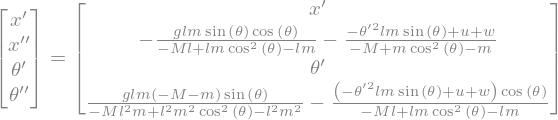

Linearized dynamics


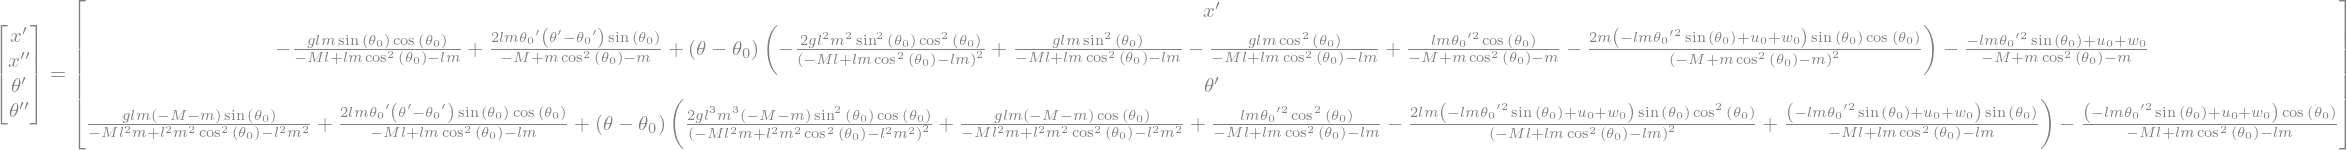

In [111]:
x, x_d, x_dd, th, th_d, th_dd = sp.symbols('x x\' x\'\' \\theta \\theta\' \\theta\'\'')   # x, x_dot, x_ddot, theta, theta_dot, theta_ddot
m, M , l, g, w, u = sp.symbols('m M l g w u')
F = u + w                           # control action + disturbance

# Calculate a direct expression for the derivatives. x_dot and theta_dot
# already known as they are part of our state, only x_ddot and theta_ddot left

# Nonlinear dynamics for d = (x_ddot, theta_ddot), A*d' = B*d
A = sp.Matrix([
    [M + m,                  -l * m * cos(th)],
    [-l * m * cos(th),     m * l ** 2]
])

b = sp.Matrix([
    -l * m * sin(th) * th_d ** 2 + F,
    g * l * m * sin(th)
])

# Compute d = (x_ddot, th_ddot) = A^-1 * b
d = A.inv() * b

# Build the full state vector z
z = sp.Matrix([x, x_d, th, th_d])
z_d = sp.Matrix([x_d, x_dd, th_d, th_dd])

# dz/dt = f(z, t), f is nonlinear
f = sp.Matrix([x_d, d[0], th_d, d[1]])
print('Nonlinear dynamics')
display(sp.Eq(z_d, f))

# In the linearization process we will need to pick a linearization point
# for our state z AND our inputs u and w
x0, x0_d, th0, th0_d, u0, w0 = sp.symbols('x_0 {x_0}\' \\theta_0 {\\theta_0}\' u_0 w_0')
z0 = sp.Matrix([x0, x0_d, th0, th0_d])
# Create the vector q for all the states we for which we insert a linearization point
# We ignore the derivates wrt. u and w, they are not interesing
q = sp.Matrix([*z, u, w])
q0 = sp.Matrix([*z0, u0, w0])

# Formula for linearization for f(x) wrt. x: f(x) = f(x0) + f'(x0)(x - x0)
f_linearized = f.subs(zip(q, q0)) + f.jacobian(z).subs(zip(q, q0))*(z-z0)
print('Linearized dynamics')
display(sp.Eq(z_d, f_linearized))


In reality, we are not interested in the full linearization, only the derivatives with respect to our state and control action.

Jacobian wrt. the control action: df / du


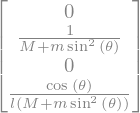

Jacobian wrt. the states: df / dz


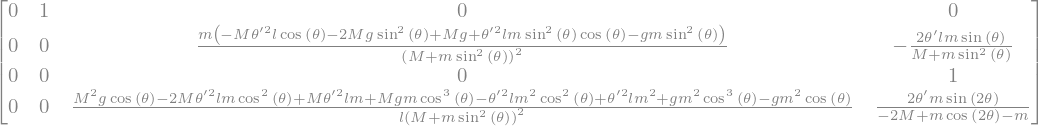

In [112]:
# In addition, w will be chosen as 0
f_sub = f.subs([(w, 0)])

df_du = f_sub.jacobian([u]); df_du.simplify()
print('Jacobian wrt. the control action: df / du')
display(df_du)

# In addition, when considering the jacobian wrt. the states
# u will be chosen as 0
f_sub = f.subs([(w, 0), (u, 0)])
df_dz = f_sub.jacobian(z); df_dz.simplify()
print('Jacobian wrt. the states: df / dz')
display(df_dz)

We are also interested in the energy in the system

Total kinetic energy: E_k


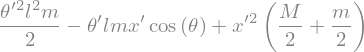

Total potential energy: E_p


In [113]:
Ek, Ep = sp.symbols('E_k, E_p')     # kinetic and potential energy
Ek = sp.Rational(1, 2) * (M + m) * x_d **2
Ek += - m * l * x_d * th_d * cos(th)
Ek += sp.Rational(1, 2) * m * l ** 2 * th_d ** 2
Ep = m * g * l * cos(th)

print('Total kinetic energy: E_k')
display(Ek)

print('Total potential energy: E_p')
display(Ep)


Export the nonlinear dynamics $f$, jacobians $\frac{df}{dz}$ and $\frac{df}{du}$ in order for us to use those equtions in the simulation

In [114]:

pkl_path = 'cart_pole/dynamics.pkl'

all_symbols = set()
all_symbols.update(f.free_symbols)
all_symbols.update(df_dz.free_symbols)
all_symbols.update(df_du.free_symbols)


with open(pkl_path, 'wb') as outfile:
    pickle.dump({'f': f, 'df_dz': df_dz, 'df_du': df_du, 'state_symbols': z,
                 'state_dot_symbols': z_d, 'u_symbol': u, 'w_symbol': w,
                 'func_symbols': all_symbols, 'Ek': Ek, 'Ep': Ep}, outfile)

print('Symbols in f')
display(f.free_symbols)
print('Symbols in df/dz')
display(df_dz.free_symbols)
print('Symbols in df/du')
display(df_du.free_symbols)
print('All symbols in functions')
display(all_symbols)

Symbols in f


Symbols in df/dz


Symbols in df/du


All symbols in functions
